In [26]:
# Завантажуємо потрібні бібліотеки

import os
import sys
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

In [27]:
# Визачаємо параметри

CUDA = True           # Використовуємо графічний процесор
DATA_PATH = './data'  # Дані будуть у папці data
BATCH_SIZE = 100      # Кількість підвибірок з даних
IMAGE_CHANNEL = 1     # Канал один - зображення це градація сірого
Z_DIM = 100           # Розмір вхідного сигналу генератора, тобто випадкових чисел для генератора
G_HIDDEN = 64         # Розмір карт об'єктів у генераторі, які поширюються через генератор
X_DIM = 64            # Вихідний розмір зображення MNIST становить 28x28. 
                      # Змінюватиму 28х28 на 64х64 з модулем ресайзу для мережі
D_HIDDEN = 64         # Розмір карт об'єктів у дискримінанті
EPOCH_NUM = 5         # Кількість епох - разів коли весь набір навчальних даних навчався у мережі
REAL_LABEL = 1        # Ця мітка буде використовуватися при розрахунку втрат дискримінатора та генератора під час навчання
FAKE_LABEL = 0        # Ця мітка буде використовуватися при розрахунку втрат дискримінатора та генератора під час навчання
lr = 2e-4             # Розмір кроку, який мережа робить при навчанні
seed = 42             # Випадкове початкове число для відтворення результатів на других компьтерах

In [28]:
# Налаштування CUDA

CUDA = CUDA and torch.cuda.is_available()
print("PyTorch version: {}".format(torch.__version__))
if CUDA:
    print("CUDA version: {}\n".format(torch.version.cuda))

if CUDA:
    torch.cuda.manual_seed(seed)
device = torch.device("cuda:0" if CUDA else "cpu")
cudnn.benchmark = True

PyTorch version: 2.0.1+cu118


In [29]:
# Підготовка даних

dataset = dset.MNIST(root=DATA_PATH, download=True,
                     transform=transforms.Compose([
                     transforms.Resize(X_DIM),
                     transforms.ToTensor(),
                     transforms.Normalize((0.5,), (0.5,))
                     ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)

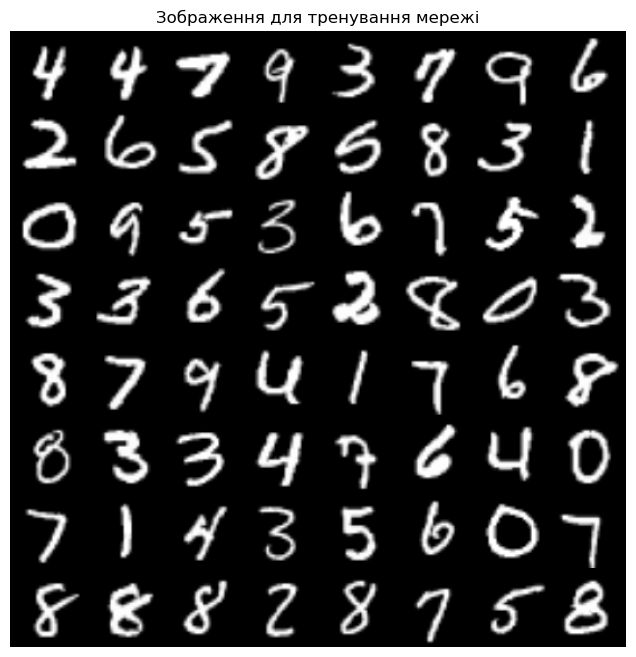

In [30]:
# Подивимось на зображення

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Зображення для тренування мережі")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


In [31]:
# Ініціалізація ваг

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [32]:
# Створюємо клас Генератор

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # вхідний шар
            nn.ConvTranspose2d(Z_DIM, G_HIDDEN * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 8),
            nn.ReLU(True),
            # 1ий прихований шар
            nn.ConvTranspose2d(G_HIDDEN * 8, G_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 4),
            nn.ReLU(True),
            # 2ий прихований шар
            nn.ConvTranspose2d(G_HIDDEN * 4, G_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 2),
            nn.ReLU(True),
            # 3ій прихований шар
            nn.ConvTranspose2d(G_HIDDEN * 2, G_HIDDEN, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN),
            nn.ReLU(True),
            # вихідний шар
            nn.ConvTranspose2d(G_HIDDEN, IMAGE_CHANNEL, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [33]:
# Створюємо клас Дискріминатор

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 1ий шар
            nn.Conv2d(IMAGE_CHANNEL, D_HIDDEN, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 2ий шар
            nn.Conv2d(D_HIDDEN, D_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 3ій шар
            nn.Conv2d(D_HIDDEN * 2, D_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 4ий шар
            nn.Conv2d(D_HIDDEN * 4, D_HIDDEN * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(D_HIDDEN * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # вихідний шар
            nn.Conv2d(D_HIDDEN * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

In [34]:
# Створюємо Генератор, екземпляр класу Генератор
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

# Створюємо Дискрімінатор, екземпляр класу Дискрімінатор
netD = Discriminator().to(device)
netD.apply(weights_init)

# ПОдивимось на іх структуру
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [35]:
# Функція втрат - Binary Cross Entropy loss
criterion = nn.BCELoss()

# Створюємо візуалізацію прогресу Генератора
viz_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device=device)

# Втановимо оптримізатори для Генератора та Дискрімінатора - Adam 
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

In [36]:
# Навчальний цикл

# Списки для відстеження прогресу
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Початок навчального циклу...")

for epoch in range(EPOCH_NUM):
    for i, data in enumerate(dataloader, 0):

        # (1) Оновлюємо Дискримінатор реальними даними
        netD.zero_grad()
        # Форматуємо пакет (BATCH)
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), REAL_LABEL, dtype=torch.float, device=device)
        # Пропускаємо пакет через Дискримінатор
        output = netD(real_cpu).view(-1)
        # Розраховуємо втрати на реальному пакеті
        errD_real = criterion(output, label)
        # Обчислюємо градієнти для Дискрімінатора під час проходу назад
        errD_real.backward()
        D_x = output.mean().item()

        # (2) Оновлюємо дискримінатор створеними даними
        # Створюємо пакет 
        noise = torch.randn(b_size, Z_DIM, 1, 1, device=device)
        # Генеруємо зображення Генератором
        fake = netG(noise)
        label.fill_(FAKE_LABEL)
        # Класифікуємо уві створені Генератором пакети за допомогою Дискримінатора
        output = netD(fake.detach()).view(-1)
        # Обчислюємо втрати 
        errD_fake = criterion(output, label)
        # Обчисліємо градієнти для цієї партії, накопичені (сумовані) з попередніми градієнтами
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Обчисліть похибку Дискриминатора як суму створеної та справжньої партій
        errD = errD_real + errD_fake
        # Оновлюємо параметри Дискримінатора через оптимізацію
        optimizerD.step()

        # (3) Оновюлємо Генератор створеними даними
        netG.zero_grad()
        label.fill_(REAL_LABEL)
        # Виконаємо ще один прямий прохід новою створеною партією через Дискримінатор
        output = netD(fake).view(-1)
        # Обчислюємо втрати Генератора на основі цього результату
        errG = criterion(output, label)
        # Обчислюємо градієнт для Генератрора
        errG.backward()
        D_G_z2 = output.mean().item()
        # Оновюлємо Генератор через оптимізацію
        optimizerG.step()

        # Вивидемо статистику навчання на кожному 50му кроці
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, EPOCH_NUM, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Збережемо втрати для візуалізації
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Перевіряємо як працює генератор, зберігши його вихідні дані
        if (iters % 500 == 0) or ((epoch == EPOCH_NUM-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(viz_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Початок навчального циклу...
[0/5][0/600]	Loss_D: 2.1814	Loss_G: 2.5114	D(x): 0.2968	D(G(z)): 0.4539 / 0.1148
[0/5][50/600]	Loss_D: 0.1014	Loss_G: 9.2293	D(x): 0.9717	D(G(z)): 0.0326 / 0.0002
[0/5][100/600]	Loss_D: 5.8062	Loss_G: 31.2387	D(x): 0.9999	D(G(z)): 0.9730 / 0.0000
[0/5][150/600]	Loss_D: 0.1854	Loss_G: 5.6061	D(x): 0.9380	D(G(z)): 0.1005 / 0.0047
[0/5][200/600]	Loss_D: 0.2574	Loss_G: 4.6532	D(x): 0.9172	D(G(z)): 0.1252 / 0.0142
[0/5][250/600]	Loss_D: 0.1526	Loss_G: 4.2609	D(x): 0.9386	D(G(z)): 0.0733 / 0.0253
[0/5][300/600]	Loss_D: 0.1571	Loss_G: 3.9379	D(x): 0.9416	D(G(z)): 0.0845 / 0.0306
[0/5][350/600]	Loss_D: 0.1606	Loss_G: 3.6348	D(x): 0.9283	D(G(z)): 0.0729 / 0.0404
[0/5][400/600]	Loss_D: 0.3217	Loss_G: 2.8902	D(x): 0.8591	D(G(z)): 0.1315 / 0.0822
[0/5][450/600]	Loss_D: 0.2228	Loss_G: 4.3616	D(x): 0.9561	D(G(z)): 0.1528 / 0.0183
[0/5][500/600]	Loss_D: 0.2045	Loss_G: 3.7489	D(x): 0.9668	D(G(z)): 0.1494 / 0.0309
[0/5][550/600]	Loss_D: 0.3409	Loss_G: 2.1946	D(x): 0.8282	D(

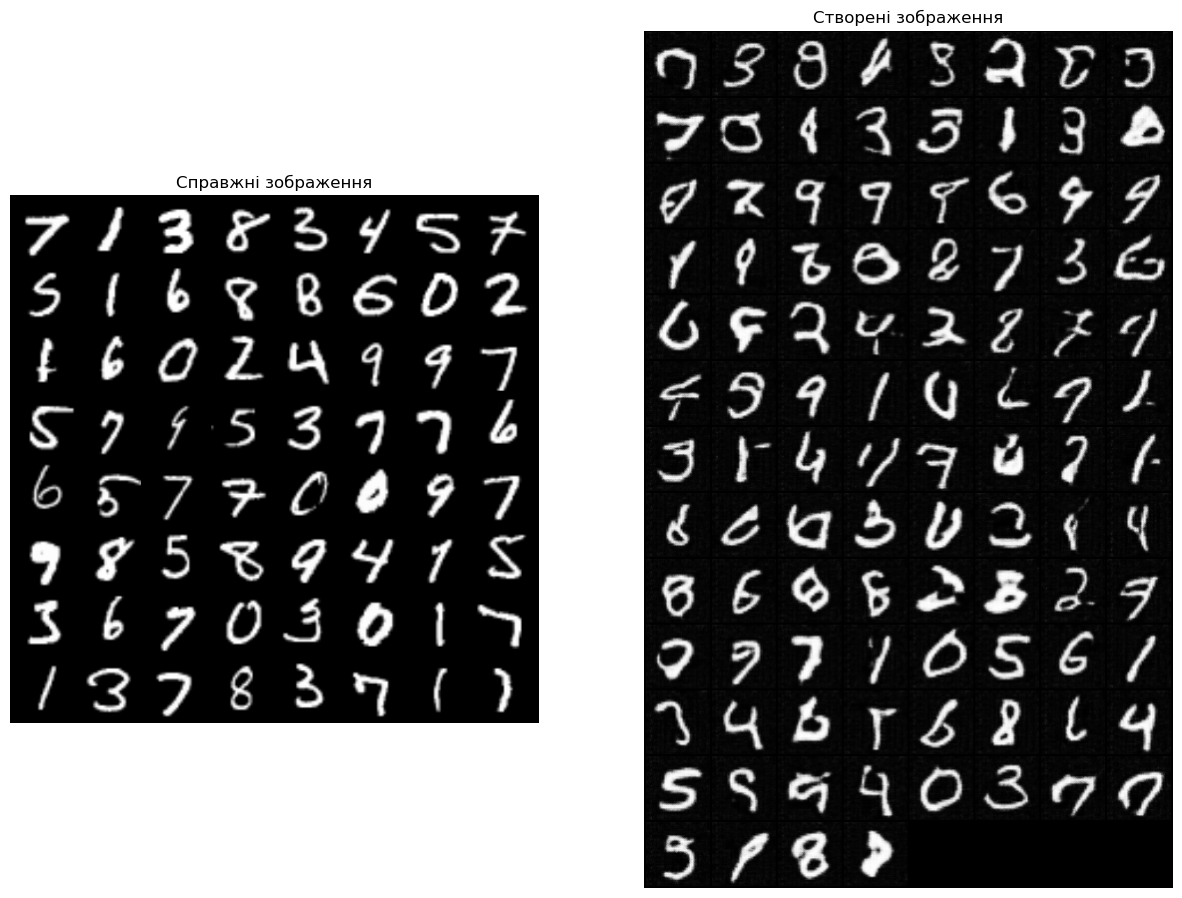

In [38]:
# Візьмемо партію реальних зображень
real_batch = next(iter(dataloader))

# Намалюємо реальні зображення
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Справжні зображення")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Намалюємо створені зображення
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Створені зображення")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [37]:
# Збереження моделі
torch.save(netG, 'modelG.pkl')
torch.save(netD, 'modelD.pkl')
